In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from tensorflow.keras import layers
from tensorflow.keras import Model


Using TensorFlow backend.


In [2]:
datadir = r'C:\Users\viral\Desktop\final_project\dataset\dataset'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-2-91e55eaddadd>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\center_2019_04_02_19_25_33_671.jpg   
1  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\center_2019_04_02_19_25_33_743.jpg   
2  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\center_2019_04_02_19_25_33_816.jpg   
3  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\center_2019_04_02_19_25_33_887.jpg   
4  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\center_2019_04_02_19_25_33_959.jpg   

                                                                                        left  \
0  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\left_2019_04_02_19_25_33_671.jpg   
1  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\left_2019_04_02_19_25_33_743.jpg   
2  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\left_2019_04_02_19_25_33_816.jpg   
3  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\left_2019_04_02_19_25_33_887.jpg   
4  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\left_2019_04_02_19_25_33_959.jpg   

                                                                                        right  \
0  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\right_2019_04_02_19_25_33_671.jpg   
1  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\right_2019_04_02_19_25_33_743.jpg   
2  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\right_2019_04_02_19_25_33_816.jpg   
3  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\right_2019_04_02_19_25_33_887.jpg   
4  C:\Users\viral\Desktop\final_project\dataset\dataset\IMG\right_2019_04_02_19_25_33_959.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.000000  0.0      0.000011  
1  0.0       0.000000  0.0      0.000007  
2  0.0       0.000000  0.0      0.000003  
3  0.0       0.048016  0.0      0.002267  
4  0.0       0.281203  0.0      0.175589

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


center                              left  \
0  center_2019_04_02_19_25_33_671.jpg  left_2019_04_02_19_25_33_671.jpg   
1  center_2019_04_02_19_25_33_743.jpg  left_2019_04_02_19_25_33_743.jpg   
2  center_2019_04_02_19_25_33_816.jpg  left_2019_04_02_19_25_33_816.jpg   
3  center_2019_04_02_19_25_33_887.jpg  left_2019_04_02_19_25_33_887.jpg   
4  center_2019_04_02_19_25_33_959.jpg  left_2019_04_02_19_25_33_959.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_04_02_19_25_33_671.jpg  0.0       0.000000  0.0      0.000011  
1  right_2019_04_02_19_25_33_743.jpg  0.0       0.000000  0.0      0.000007  
2  right_2019_04_02_19_25_33_816.jpg  0.0       0.000000  0.0      0.000003  
3  right_2019_04_02_19_25_33_887.jpg  0.0       0.048016  0.0      0.002267  
4  right_2019_04_02_19_25_33_959.jpg  0.0       0.281203  0.0      0.175589

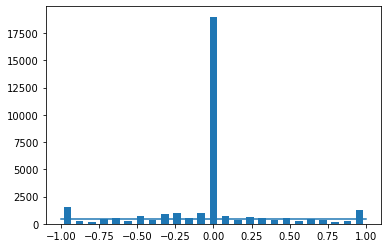

In [4]:
# visualize the distribution
num_bins = 25 # odd number
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5 # -1 to 1, center of 0
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [5]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 

total data: 32443


In [6]:
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 23671
remaining: 8772


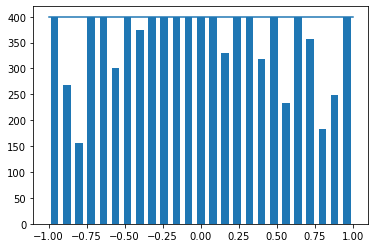

In [7]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [8]:

print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 

center      center_2019_04_02_19_25_35_440.jpg
left        left_2019_04_02_19_25_35_440.jpg  
right       right_2019_04_02_19_25_35_440.jpg 
steering   -0.05                              
throttle    0                                 
reverse     0                                 
speed       6.07434                           
Name: 25, dtype: object


Training Samples: 21052
Valid Samples: 5264


Text(0.5, 1.0, 'Validation set')

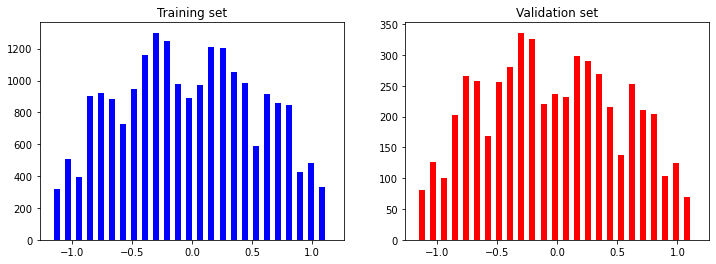

In [9]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

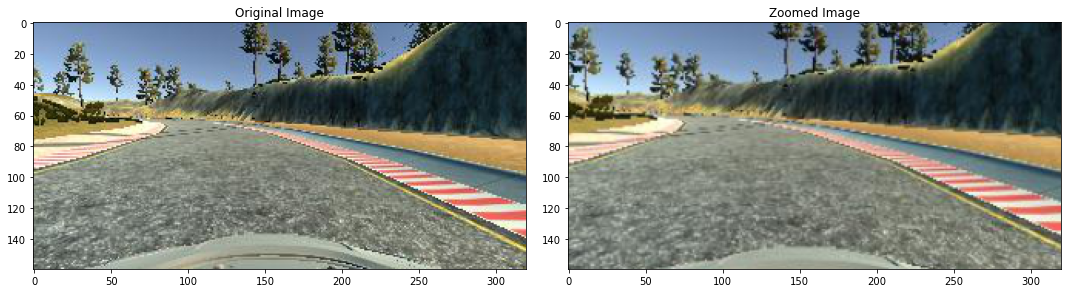

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


Text(0.5, 1.0, 'Panned Image')

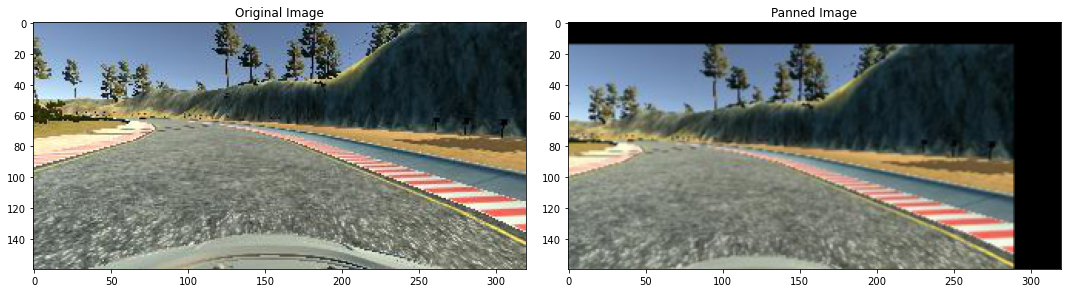

In [12]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')


Text(0.5, 1.0, 'Brightness altered image ')

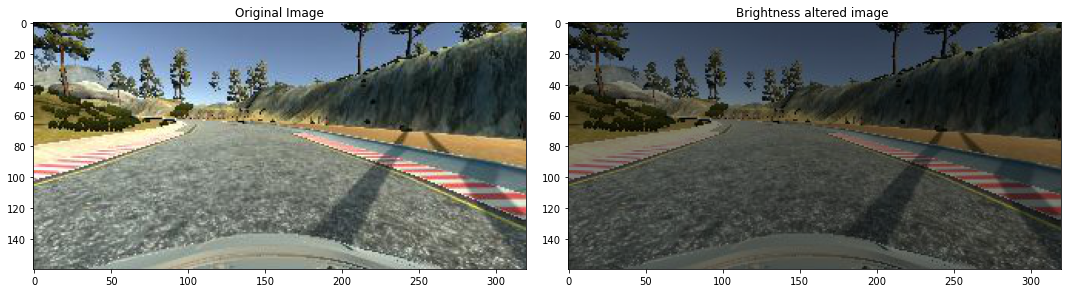

In [13]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')


Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

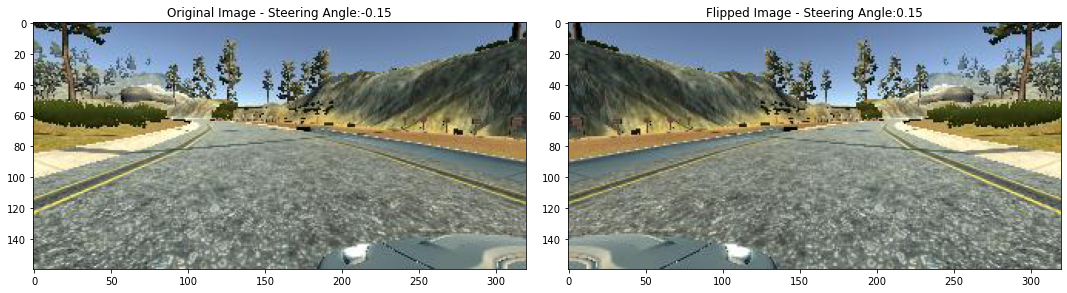

In [14]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))


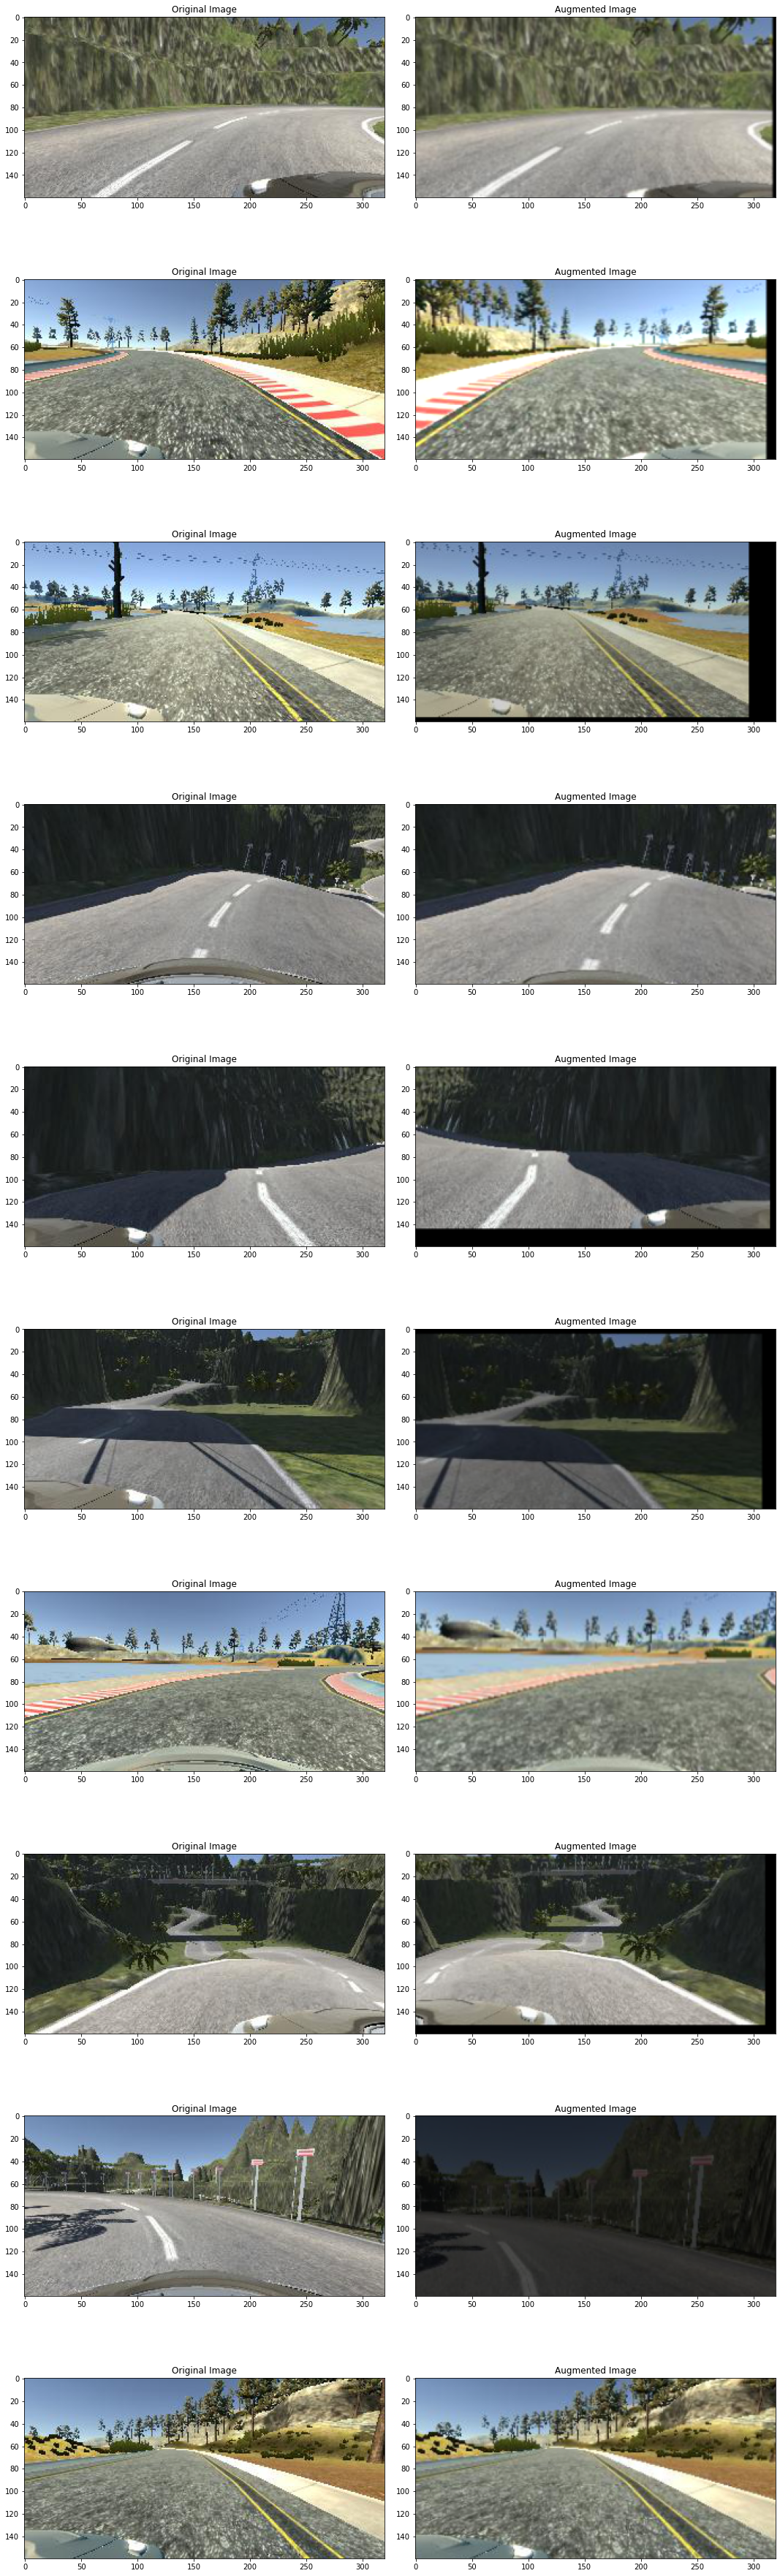

In [15]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")


Text(0.5, 1.0, 'Preprocessed Image')

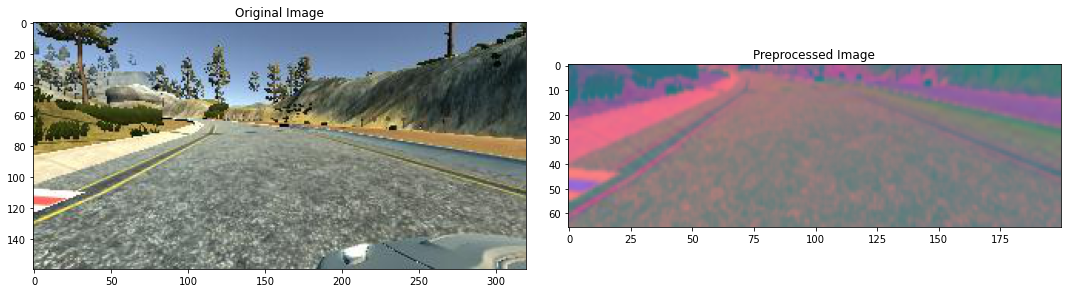

In [16]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Text(0.5, 1.0, 'Validation Image')

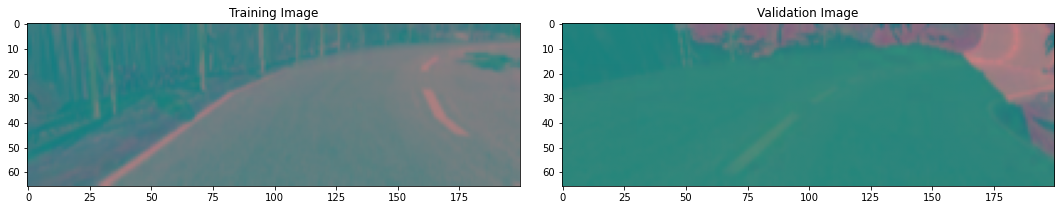

In [17]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  
    
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [20]:
def nvidia_model():
    img_input = layers.Input(shape=(66, 200, 3))
    x = layers.Conv2D(24, 5, (2, 2), activation='elu')(img_input)
    #x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(36, 5,(2, 2), activation='elu')(x)
    #x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(48, 5,(2, 2), activation='elu')(x)
    #x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3,(1, 1), activation='relu')(x)
    #x = layers.MaxPooling2D(1)(x)
    x = layers.Conv2D(64,1, (2, 2), activation='relu')(x)
    #x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='elu')(x)
    x = layers.Dense(50, activation='elu')(x)
    x = layers.Dense(10, activation='elu')(x)
    output = layers.Dense(1)(x)
    model = Model(img_input, output)
    model.summary()
  
    optimizerz = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-3),metrics=['accuracy'])
    return model

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 10, 64)         4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)             

ModuleNotFoundError: No module named 'google.colab'

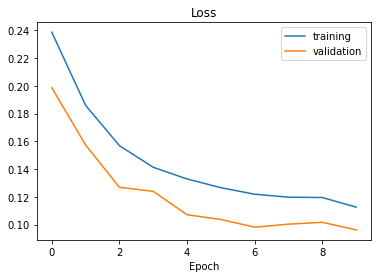

In [21]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')
